In [1]:
import numpy as np
import scipy as sc
from openpmd_viewer import OpenPMDTimeSeries
import matplotlib.pyplot as plt
import time

import analysis as an
import beam_info as bi
import visual as vis
import heavy_computing as hc

In [2]:
# single scan functions

def two_Gaussians(x,A0,A1,mu0,mu1,sig0,sig1):
        return A0 * np.exp(-0.5*((x-mu0)/sig0)**2) + A1 * np.exp(-0.5*((x-mu1)/sig1)**2)
    
def Lorentz_Gauss(x,A0,A1,mu0,mu1,sig0,sig1):
    return A0 * np.exp(-0.5*((x-mu0)/sig0)**2) + A1 * sig1**2/((x - mu1)**2 + sig1**2)
        
def Gaussian(x,A,mu,sig):
    return A * np.exp(-0.5 * ((x-mu)/sig)**2)

def single_E_epsilon_scan(plt_traj):
    fig_E,axes_E = plt.subplots(1,2,figsize = (8,3))

    plt_traj.E_gain(section = 'tail',axes = axes_E[0],color = 'b',linestyle = 'dashdot',linewidth = None,label = 'tail charge')
    plt_traj.E_gain(section = 'entire',axes = axes_E[0],color = 'k',linestyle = '-',linewidth = None,label = 'total charge')
    
    plt_traj.emittance(section = 'tail',axes = axes_E[1],color = 'b',linestyle = 'dashdot',linewidth = None,label = 'tail charge')
    plt_traj.emittance(section = 'entire',axes = axes_E[1],color = 'k',linestyle = '-',linewidth = None,label = 'total charge')
    
    axes_E[0].legend()
    axes_E[1].yaxis.tick_right()
    axes_E[1].yaxis.set_label_position('right')
    
    axes_E[0].set_title('E gain')
    axes_E[1].set_title('Emittance growth')
    
    axes_E[0].set_ylabel('E (GeV)')
    axes_E[0].set_xlabel(r'$z$ (cm)')
    axes_E[1].set_ylabel(r'$\epsilon / \epsilon_0$ (mm)')
    axes_E[1].set_xlabel(r'$z$ (cm)')
    plt.tight_layout()

    return fig_E,axes_E

def single_beam_size_scan(plt_traj,L_plot,beam_params):

    fig_beta,axes_beta = plt.subplots(1,2,figsize = (8,3))
    
    z_sim,beta_sim = plt_traj.bf_in_sims(section = 'tail',axes = axes_beta[0],color = 'g',linestyle = None,linewidth = None,label = f'{np.round(beam_params['tail_c']*1e9,2)} nC')
    
    z_vac,beta_vac = plt_traj.bf_in_vac(section = 'tail',L = L_plot,axes = axes_beta[0],color = 'g',linestyle = None,linewidth = None,label = None)
    z_min = z_vac[np.argmin(beta_vac)]
    beta_min = np.min(beta_vac)  
    
    z,sig = plt_traj.full_beam_size_evln(section = 'tail', L = L_plot, axes = axes_beta[1],color = 'g',linestyle = None,linewidth = None,label = f'{np.round(beam_params['tail_c']*1e9,2)} nC')
    sig_min = np.min(sig)
    
    axes_beta[0].legend()
    axes_beta[1].yaxis.tick_right()
    axes_beta[1].yaxis.set_label_position('right')
    
    axes_beta[0].set_title('Betafunction')
    axes_beta[1].set_title('Beam transverse size')
    
    axes_beta[0].set_ylabel(r'$\beta$ (cm)')
    axes_beta[0].set_xlabel(r'$z$ (cm)')
    axes_beta[1].set_ylabel(r'$\sigma$ ($\mu$m)')
    axes_beta[1].set_xlabel(r'$z$ (cm)')
    
    axes_beta[0].tick_params(right=True,direction = 'in')
    axes_beta[1].tick_params(left=True,direction = 'in')
    
    print(f"z_min = {np.round(z_min,2)} cm; beta_min = {np.round(beta_min,2)} cm; sig_min = {np.round(sig_min,2)} um")

    return fig_beta,z_min,beta_min,sig_min
    
def single_scan_E_x(plt_traj,L,detect_threshold,model):
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (8,4))
    
    H, xedges, yedges = plt_traj.E_x_plot_info(L= L,detect_threshold = detect_threshold,axes = ax1)
    ax_E_dist = ax1.twiny()
    ax_E_dist.plot(np.sum(H,axis = 0),yedges[:-1],c = 'r',linestyle = '-',linewidth = 1)
    
    ax_E_dist.tick_params(axis='x', labelcolor = 'r')
    ax_E_dist.set_xlabel('y bin', color = 'r')
    
    ax1.set_xlabel(r'x ($\mu$m)')
    ax1.set_ylabel(r'E (GV)')
    
    x_range = xedges[:-1]*1e6
    y_range = np.sum(H,axis = 1)
    plot_x_range = np.linspace(np.min(x_range),np.max(x_range),num = 10**4)
    
    ax2.plot(x_range,y_range,c = 'r',linestyle = '-',label = 'beam count')
        
    popt,pcov = sc.optimize.curve_fit(model,x_range,y_range,p0 = [np.max(y_range),np.max(y_range)/3,0,0,1,10])
    
    ax2.plot(plot_x_range,model(plot_x_range,*popt),c = 'b',linestyle = '--',linewidth = 1,label = 'fit')
    
    ax2.plot(plot_x_range,Gaussian(x = plot_x_range,A = popt[0],mu = popt[2],sig = popt[4]),linewidth = 1,linestyle = 'dotted')
    ax2.plot(plot_x_range,Gaussian(x = plot_x_range,A = popt[1],mu = popt[3],sig = popt[5]),linewidth = 1,linestyle = 'dotted')
    
    ax2.legend()
    ax2.set_xlabel(r'x ($\mu$m)')
    ax2.set_ylabel(r'number of macro-particles')
    #ax2.set_xlim((-50,50))
    
    Q_foc = np.trapz(Gaussian(x = plot_x_range,A = popt[0],mu = popt[2],sig = popt[4]), x = plot_x_range)/np.trapz(model(plot_x_range,*popt),x = plot_x_range) * beam_params['tot_c'] * 1e9
    HWHM = np.sqrt(2*np.log(2))*popt[4]
    
    print(f'Focused charge: {np.round(Q_foc,2)} nC; HWHM: {HWHM}')
    plt.tight_layout()

    return fig,Q_foc,HWHM

def precent_charge_in_ellipse(contour_params,ellipse_params):
    H,xedges,yedges = contour_params
    a,b,g,emit = ellipse_params
    
    xrange_contour = (xedges[:-1] + xedges[1:])/2
    yrange_contour = (yedges[:-1] + yedges[1:])/2

    count = 0
    
    for x_idx in range(len(xrange_contour)):
        x = xrange_contour[x_idx]
        
        if np.abs(x) < np.sqrt(emit*b):
            
            def ts_ellipse(y):
                return g*x**2 + 2*a*x*y + b*y**2 - emit
            y_ell_min = fsolve(ts_ellipse,[-np.sqrt(g*emit)],maxfev=10**5)
            y_ell_max = fsolve(ts_ellipse,[np.sqrt(g*emit)],maxfev=10**5)
            
            for y_idx in range(len(yrange_contour)):
                
                y = yrange_contour[y_idx]
                
                if (y > y_ell_min) & (y < y_ell_max):
                    count += H[x_idx][y_idx]

    return count/np.sum(np.sum(H))

In [3]:
# functions needing parallelization
def scan_tail_charges(tail_charges,ts,beam_params):
    
    colors = ['k','b','r','g']
    L = 4
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (8,4))
    
    for _ in range(len(tail_charges)):
        
        tail_charge = tail_charges[_]
        color = colors[_]
        
        beam = bi.get_beam_info(ts = ts,beam = 'driver',iteration = 0,tail_charge = tail_charge,tot_charge = beam_params['tot_c'],dt = beam_params['dt'],num_bins = 100)
    
        plt_traj = vis.plot_trajectory(beam = beam)
    
        plt_traj.bf_in_sims(section = 'tail',axes = ax1,color = color,linestyle = None,linewidth = None,label = f'{np.round(tail_charge*1e9,2)} nC')

        plt_traj.bf_in_vac(L = L,section = 'tail',axes = ax1,color = color,linestyle = None,linewidth = None,label = None)
    
        plt_traj.full_beam_size_evln(L = L,section = 'tail',axes = ax2,color = color,linestyle = None,linewidth = None,label = None)
    
    ax1.legend()
    ax1.set_ylabel(r'$\beta_x$',fontsize = 15)
    ax2.set_ylabel(r'$\sigma_x$',fontsize = 15)

    return fig

def scan_E_x():
    
    run_name = 'TUPPL/FACET_shift/optimized_nozz/'
    directory = '/Users/mengshutang/desktop/CU_PWFA/COMPUTATIONS/HiPACE/runs/'
    
    dat_lst = ['15um','20um','25um','30um','35um','40um']
    c_lst = ['k','grey','b','r','g','orange']
    count = -1
    L_lst = np.linspace(0,5,num = 11)*1e-2
    
    fig,ax = plt.subplots(1,1)
        
    for data in dat_lst:
        
        count += 1
        Q = np.zeros(len(L_lst))
        ts = OpenPMDTimeSeries(directory + run_name + data + '/diags/hdf5')
        tail_c = .3e-9
        tot_c = 1.6e-9
        dt = 1e-14
        n0 = 1e16
        iteration = 0
        beam = bi.get_beam_info(ts = ts,beam = 'driver',iteration = iteration,tail_charge = tail_c,tot_charge = tot_c,dt = dt,num_bins = 100)
        
        # 2D plot info
        plt_traj = vis.plot_trajectory(beam = beam)
        print(data)
        
        for i in range(len(L_lst)):
            print(L_lst[i])
            
            fig_null,ax_null = plt.subplots(1,1)
    
            H, xedges, yedges = plt_traj.E_x_plot_info(L = L_lst[i],detect_threshold=None,axes = ax_null)
            
            x_range = xedges[:-1]*1e6
            y_range = np.sum(H,axis = 1)
            
            plot_x_range = np.linspace(np.min(x_range),np.max(x_range),num = 10**4)   
            popt,pcov = sc.optimize.curve_fit(Lorentz_Gauss,x_range,y_range,p0 = [50000,20000,0,0,1,10])

            Q_foc = np.trapz(Gaussian(x = plot_x_range,A = popt[0],mu = popt[2],sig = popt[4]), x = plot_x_range)/np.trapz(Lorentz_Gauss(plot_x_range,*popt),x = plot_x_range) * tot_c * 1e9
    
            Q_unfoc = np.trapz(Gaussian(x = plot_x_range,A = popt[1],mu = popt[3],sig = popt[5]), x = plot_x_range)/np.trapz(Lorentz_Gauss(plot_x_range,*popt),x = plot_x_range) * tot_c * 1e9
    
            Q[i] = Q_foc
    
        ax.scatter(L_lst*1e2,Q,c = c_lst[count],label = data)
        ax.plot(L_lst*1e2,Q,c = c_lst[count])

    ax.set_xlabel('z (cm)')
    ax.set_ylabel('Focused charges (nC)')
    ax.axvline(x = 0.0125*1e2,linestyle = '--')
    ax.legend()

In [4]:
### read single scan data

run_name = 'TUPPL/FACET_shift/UCLA_nozzle/'
data = '30um'
directory = '/Users/mengshutang/desktop/CU_PWFA/COMPUTATIONS/HiPACE/runs/'

dirs = directory + run_name
ts = OpenPMDTimeSeries(dirs + data + '/diags/hdf5')

beam_params = {'tail_c': .3e-9,
              'tot_c': 1.6e-9,
              'dt': 1e-14,
              'n0': 1e16,
              'iteration': 0}

beam = bi.get_beam_info(ts = ts,beam = 'driver',iteration = beam_params['iteration'],tail_charge = beam_params['tail_c'],tot_charge = beam_params['tot_c'],dt = beam_params['dt'],num_bins = 100)

# 2D plot info
plt_traj = vis.plot_trajectory(beam = beam)

beam.print_beam_info(section = 'None')

Beam species: driver None
Distance traveled: 0.0 cm
Beam spot size: sig_x = 29.968 um; sig_y = 29.906 um.
Normalized emittance: eps_x = 35.211 um; eps_y = 35.109 um.
Twiss parameters: a_xy = 0.001,-0.002; b_xy = 0.499,0.499; g_xy = 2.003,2.006.


z_min = 1.89 cm; beta_min = 0.45 cm; sig_min = 10.74 um
Focused charge: 0.18 nC; HWHM: 1.7788853566391105


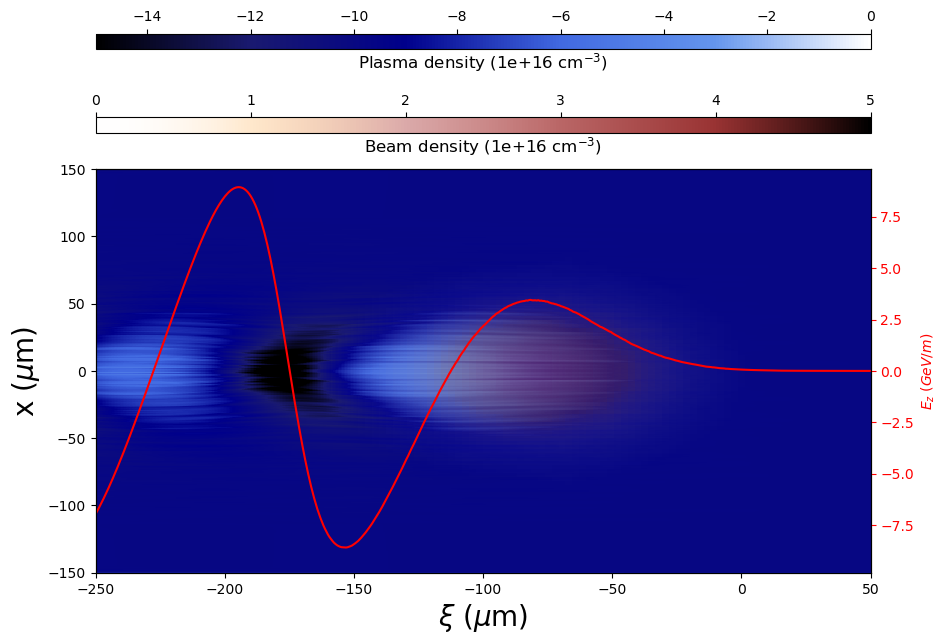

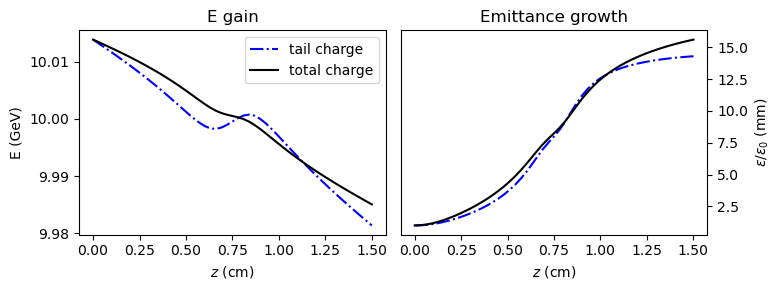

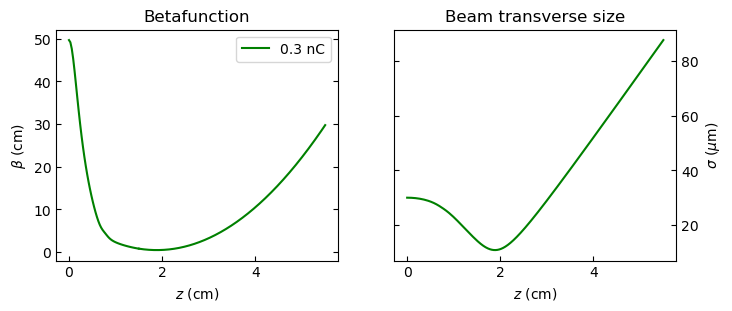

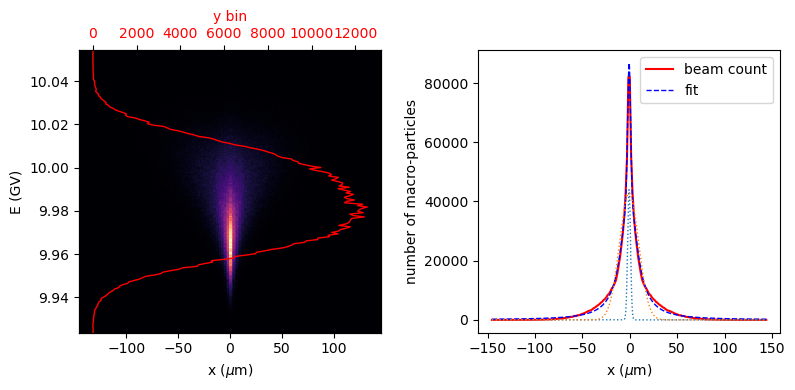

In [5]:
#---------------- PWFA plot ------------------
iteration = 2500

# PWFA plot info
PWFA_plot = vis.visual(ts,iteration,beam_params['n0'])

fig,ax = plt.subplots(1,1,figsize = (10,8))
ax.set_xlabel(r'$\xi$ ($\mu$m)',fontsize = 20)
ax.set_ylabel(r'x ($\mu$m)',fontsize = 20)

PWFA_plot.plot_field(axes = ax,vmin = -15,plot_number_density = True)
PWFA_plot.plot_beam(beam_info = beam,plot_number_density = True,bin_y = True,axes = ax,vmax = 5)

#-------------- E & eps plot ----------------
fig_E,axes_E = single_E_epsilon_scan(plt_traj)

#------------- beam size -------------------
fig_beta, z_min, beta_min, sig_min = single_beam_size_scan(plt_traj = plt_traj,L_plot = 4,beam_params = beam_params) 

fig_E_x, Q_foc, HWHM = single_scan_E_x(plt_traj = plt_traj,L = z_min*1e-2,detect_threshold = None,model = Lorentz_Gauss)

In [6]:
# scan tail charges
#fig = scan_tail_charges(tail_charges = np.linspace(.1,.4,4)*1e-9,ts = ts,beam_params = beam_params)

In [7]:
# scan various beam sizes
#data_lst = ['20um','30um']
#c_lst = ['k','b']
#L_plot = 3
#hc.multiple_beam_sizes(dirs = dirs,data_lst = data_lst,c_lst = c_lst,beam_params = beam_params,L_plot = L_plot)

Focused charge: 0.31 nC; HWHM: 4.137527538642129


/var/folders/1_/d86r7cfn7nbb663qcn5ld6qr0000gn/T/ipykernel_27531/449817067.py:52: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for level, line in zip(contour.levels, contour.collections):


charge enclosed: 0.246 nC


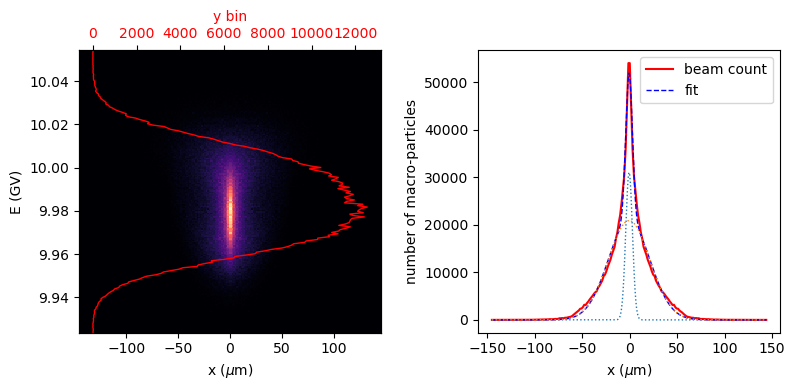

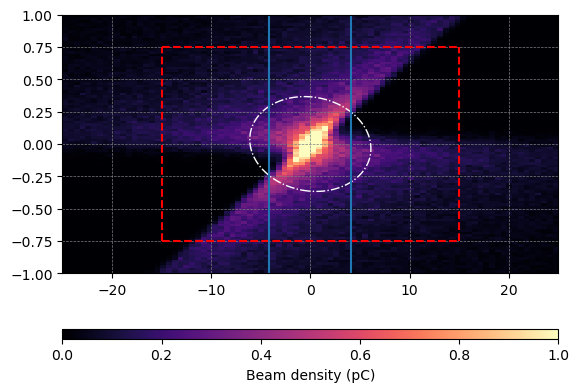

In [8]:
from matplotlib.patches import Ellipse
from scipy.optimize import fsolve

L = 3e-2
model = two_Gaussians
box_size = {'x_p': .75e-3,'x': 15e-6}

#-------------E_x plot ------------
fig_E_x, Q_foc, HWHM = single_scan_E_x(plt_traj = plt_traj,L = L,detect_threshold = None,model = model)

#------------ trace space profile -------
bin_num = 500

fig,axes = plt.subplots()
x,x_p,pz = plt_traj.trace_space(L = L)
H, xedges, yedges = np.histogram2d(x, x_p, bins=[bin_num,bin_num])

# plot 2d histogram
vmax = 1e-12/beam_params['tot_c'] * len(x)
beam = axes.pcolormesh(xedges*1e6, yedges*1e3, H.T/vmax, cmap='magma',vmax = 1)
cb_beam = plt.colorbar(beam, ax=axes, location='bottom', aspect=50, pad=0.15,label = 'Beam density (pC)')

axes.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
axes.set_xlim(-25, 25)
axes.set_ylim(-1, 1)

axes.plot([box_size['x']*1e6 for _ in range(1000)],np.linspace(-box_size['x_p']*1e3,box_size['x_p']*1e3,num = 1000),c = 'r',linestyle = '--')
axes.plot([-box_size['x']*1e6 for _ in range(1000)],np.linspace(-box_size['x_p']*1e3,box_size['x_p']*1e3,num = 1000),c = 'r',linestyle = '--')
axes.plot(np.linspace(-box_size['x']*1e6,box_size['x']*1e6,num = 1000),[box_size['x_p']*1e3 for _ in range(1000)],c = 'r',linestyle = '--')
axes.plot(np.linspace(-box_size['x']*1e6,box_size['x']*1e6,num = 1000),[-box_size['x_p']*1e3 for _ in range(1000)],c = 'r',linestyle = '--')

# ellipse
select = (np.abs(x_p) <= box_size['x_p'])&(np.abs(x) <= box_size['x'])
do_select = True

if do_select:
    x_cut = x[select]
    x_p_cut = x_p[select]
else:
    x_cut = x
    x_p_cut = x_p

a,b,g = an.twiss_params(x_cut,x_p_cut)
emit = an.ts_emittance_rms(x_cut,x_p_cut)

xrange = np.linspace(xedges[0], xedges[-1], 10**3)
yrange = np.linspace(yedges[0], yedges[-1], 10**3)

X,Y,Z = an.plot_ts_ellipse(xrange, yrange, emit, a, b, g)
contour = axes.contour(X*1e6, Y*1e3, Z, levels=[0], colors='white')
        
for level, line in zip(contour.levels, contour.collections):
    line.set_linestyle('dashdot') 
    line.set_linewidth(1) 
axes.axvline(x = HWHM)
axes.axvline(x = -HWHM)
charge_enclosed = precent_charge_in_ellipse([H,xedges,yedges],[a,b,g,emit])*1.6e-9
print(f'charge enclosed: {np.round(charge_enclosed*1e9,3)} nC')